# Imports

In [9]:
import tensorflow as tf
import cv2
# from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


2024-06-10 11:49:15.607443: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 11:49:15.607539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 11:49:15.761464: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
import keras
keras.__version__

'3.3.3'

# Dataset

# Saving to kaggle

In [3]:
import os
import json

from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()

os.environ['KAGGLE_USERNAME'] = secrets.get_secret("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = secrets.get_secret("KAGGLE_KEY")

In [ ]:
dataset_dir = 'kaggle/working'

In [ ]:

with open(os.path.join(dataset_dir,'dataset-metadata.json'), 'w') as f:
    json.dump(meta, f)
    

In [ ]:
!kaggle datasets create -p {dataset_dir} --dir-mode zip

# Data Exploration .

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import threading

def display_images_in_grid(image_paths, grid_size):
    """
    Display images in a grid.

    Parameters:
    image_paths (list): List of image file paths.
    grid_size (tuple): Number of rows and columns in the grid.
    """
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 10))
    axes = axes.flatten()
    lock = threading.Lock()
    img_arr = [None] * len(image_paths)
    def get_arr(i):
        img = mpimg.imread(image_paths[i])
        # with lock:
        img_arr[i] = img

    threads = []
    for i, img_path in enumerate(image_paths):
        th = threading.Thread(target = get_arr, args = [i])
        threads.append(th)
        th.start()
    for th in threads:
        th.join()

    # print(image_paths)

    for ax,arr in zip(axes,img_arr):
        ax.imshow(arr)
        ax.axis('off')
    # Hide remaining axes if there are fewer images than grid cells
    for ax in axes[len(image_paths):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
_ = cv2.imread('gtFine/test/berlin/berlin_000000_000019_gtFine_color.png')
cv2_imshow(_)

In [ ]:
path_lists.image_file_names[10:13]

In [ ]:
_ = leftimg.get_filtered_list(
    lambda x : x.startswith('leftImg8bit/train/') and x.endswith('.png'),
    start = 5, end = 10
    )

In [ ]:
_ = leftimg.download_with_filter(
    lambda x : x.startswith('leftImg8bit/train/') and x.endswith('.png'),
    start = 5, end = 10
    )

In [ ]:
display_images_in_grid(
    leftimg.get_filtered_list(
    lambda x : x.startswith('rightImg8bit/train/') and x.endswith('.png'),
    start = 5, end = 10
    ),
    [3,2]
)

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(arr)

# Data Preprocessing

## Input Pipeline

In [11]:
gtFine_dir = '/kaggle/input/image-map-cityscapes-19510/gtFine_trainvaltest/gtFine'
leftImg8bit_dir = '/kaggle/input/image-map-cityscapes-19510/leftImg8bit_trainvaltest/leftImg8bit'

In [12]:
segment_list = [os.path.join(root, file)
            for root, dirs, files in os.walk(gtFine_dir)
            for file in files]

image_list = [os.path.join(root, file)
            for root, dirs, files in os.walk(leftImg8bit_dir)
            for file in files]

segment_list.sort()
image_list.sort()


In [13]:
output_files = [f for f in image_list if f.endswith('.png')]

In [14]:
train_x = [f for f in output_files if f.startswith(os.path.join(leftImg8bit_dir,'train'))]
val_x = [f for f in output_files if f.startswith(os.path.join(leftImg8bit_dir,'val'))]
# test_x = [f for f in output_files if f.startswith('leftImg8bit/test')]

In [15]:
train_y_label = [f for f in segment_list if f.startswith(os.path.join(gtFine_dir,'train')) and f.endswith('gtFine_labelIds.png')]
val_y_label = [f for f in segment_list if f.startswith(os.path.join(gtFine_dir,'val')) and f.endswith('gtFine_labelIds.png')]
# test_y_label = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/test') and f.endswith('gtFine_labelIds.png')]

In [16]:
train_y_color = [f for f in segment_list if f.startswith(os.path.join(gtFine_dir,'train')) and f.endswith('gtFine_color.png')]
val_y_color = [f for f in segment_list if f.startswith(os.path.join(gtFine_dir,'val')) and f.endswith('gtFine_color.png')]
# test_y_color = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/test') and f.endswith('gtFine_color.png')]

In [17]:
len(train_y_label)

2975

In [18]:
len(val_y_label)

500

In [19]:
import tensorflow as tf

class Preprocessor:
    def __init__(
            self,
            filepaths : list[str]
    ):
        self.filepaths = filepaths
        self.dataset = None





    def get_dataset_iterator(self,func):
        if self.dataset:
            return self.dataset

        self.dataset = tf.data.Dataset.from_tensor_slices(self.filepaths)

        self.dataset = self.dataset.map(func, num_parallel_calls=tf.data.AUTOTUNE)

        # self.dataset = self.dataset.cache()
        # self.dataset = self.dataset.shuffle(buffer_size=1000)
        # self.dataset = self.dataset.batch(32)
        # self.dataset = self.dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        return self.dataset
@tf.function
def load_preprocess_y(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [128, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image
    
@tf.function
def load_preprocess_x(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 256])
    image = image / 255.0
    return image

In [20]:
train_ds_x = Preprocessor(train_x).get_dataset_iterator(load_preprocess_x)
val_ds_x = Preprocessor(val_x).get_dataset_iterator(load_preprocess_x)
# test_ds_x = Preprocessor(test_x).get_dataset_iterator()


In [21]:
train_y,val_y = train_y_label,val_y_label
# train_y,val_y = train_y_color,val_y_color



In [22]:
train_ds_y = Preprocessor(train_y).get_dataset_iterator(load_preprocess_y)
val_ds_y = Preprocessor(val_y).get_dataset_iterator(load_preprocess_y)
# test_ds_y = Preprocessor(test_x).get_dataset_iterator()

In [23]:
dataset_train = tf.data.Dataset.zip(train_ds_x, train_ds_y)
dataset_val = tf.data.Dataset.zip(val_ds_x, val_ds_y)


In [24]:
train_ds_x.as_numpy_iterator().next().shape

(128, 256, 3)

In [25]:
def optimize_datasets(dataset):
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=20)
        dataset = dataset.batch(16)
        dataset = dataset.prefetch(buffer_size=2)
        return dataset

In [26]:
dataset_train = optimize_datasets(dataset_train)
dataset_val = optimize_datasets(dataset_val)

In [27]:
temp = dataset_val.as_numpy_iterator().next()

In [28]:
x = (temp[0][1])
y = (temp[1][1])

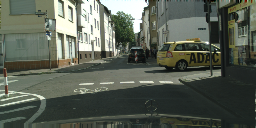

In [29]:
keras.utils.array_to_img(x)

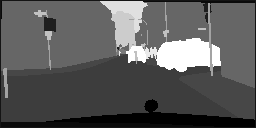

In [30]:
keras.utils.array_to_img(y)

# NN

### Initializing credentials

In [70]:
import os
import json

from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()

os.environ['KAGGLE_USERNAME'] = secrets.get_secret("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = secrets.get_secret("KAGGLE_KEY")

### Creating Model

In [ ]:
model_meta_data = {
  "ownerSlug": "patagobhi123",
  "title": "SegCeption_b60",
  "slug": "segception-b60",
  "subtitle": "",
  "isPrivate": True,
  "description": "# Model Summary\n\n# Model Characteristics\n\n# Data Overview\n\n# Evaluation Results\n",
  "publishTime": "",
  "provenanceSources": ""
}

In [ ]:

with open(os.path.join('/kaggle/working','model-metadata.json'), 'w') as f:
    json.dump(model_meta_data, f)
    

In [ ]:
#  !kaggle models create --path /kaggle/working

### Creating Model Instance

In [ ]:
import os, json

In [ ]:
dir_to_new_model = '/kaggle/working'

In [ ]:
# Edit model metadata here
model_instance_meta_data = {
  "ownerSlug": "ishansrivastava1308",
  "modelSlug": "v1",
  "instanceSlug": "Segception9",
  "framework": "keras",
  "overview": "",
  "usage": "# Model Format\n\n# Training Data\n\n# Model Inputs\n\n# Model Outputs\n\n# Model Usage\n\n# Fine-tuning\n\n# Changelog\n",
  "licenseName": "Apache 2.0",
  "fineTunable": True,
  "trainingData": [],
  "modelInstanceType": "Unspecified",
  "baseModelInstanceId": 0,
  "externalBaseModelUrl": ""
}

In [ ]:
# !kaggle models instances delete ishansrivastava1308/v1/keras/b32_3_5_9

In [ ]:

with open(os.path.join('/kaggle/working','model-instance-metadata.json'), 'w') as f:
    json.dump(model_instance_meta_data, f)
    

In [ ]:
!kaggle models instances create -p /kaggle/working --dir-mode tar

## Creating Model Version

In [71]:
!kaggle models instances versions create ishansrivastava1308/v1/keras/segception9 -p /kaggle/working --dir-mode tar

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Starting upload for file Segception_b60_epoch_40.keras
100%|████████████████████████████████████████| 108M/108M [00:01<00:00, 79.7MB/s]
Upload successful: Segception_b60_epoch_40.keras (108MB)
Starting upload for file Segception_b60_epoch_35.keras
100%|█████████████████████████████████████████| 108M/108M [00:00<00:00, 115MB/s]
Upload successful: Segception_b60_epoch_35.keras (108MB)
Starting upload for file logs.tar
100%|██████████████████████████████████████| 20.4M/20.4M [00:00<00:00, 38.2MB/s]
Upload successful: logs.tar (20MB)
Starting upload for file .virtual_documents.tar
100%|██████████████████████████████████████| 10.0k/10.0k [00:00<00:00, 30.3kB/s]
Upload successful: .virtual_documents.tar (10KB)
Your model instance version was created. Url=https://www.kaggle.com/models/ishansrivastava1308/v1/Keras/segception9/2


# Metrics

In [31]:
import keras

In [24]:
class MeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super(MeanIoU, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.iou_class = keras.metrics.MeanIoU(num_classes=self.num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        self.iou_class.update_state(y_true=y_true, y_pred=y_pred)
        self.total_iou.assign(self.iou_class.result())

    def result(self):
        return self.total_iou

    def reset_state(self):
        self.total_iou.assign(0.0)

mean_iou = MeanIoU(34)

In [25]:
accuracy_metric = keras.metrics.SparseCategoricalAccuracy()

# Custom Modelling

In [50]:
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,ReLU,BatchNormalization,Concatenate,MaxPool2D,UpSampling2D,Add,PReLU
from tensorflow.keras import Input,Model

In [ ]:
def deep_stack_module(inp,filters):
    c_3_1 = Conv2D(filters,3, padding = 'same')(inp)
    c_3_1 = BatchNormalization()(c_3_1)
    c_3_1 = ReLU()(c_3_1)

    c_3_31 = Conv2D(filters,(3,1), padding = 'same')(c_3_1)
    c_3_31 = BatchNormalization()(c_3_31)
    c_3_31 = ReLU()(c_3_31)

    c_3_13 = Conv2D(filters,(1,3), padding = 'same')(c_3_1)
    c_3_13 = BatchNormalization()(c_3_13)
    c_3_13 = ReLU()(c_3_13)

    c_3_2 = Conv2D(filters,3, padding = 'same')(c_3_1)
    c_3_2 = BatchNormalization()(c_3_2)
    c_3_2 = ReLU()(c_3_2)

    c_5 = Conv2D(filters,5, padding = 'same')(inp)
    c_5 = BatchNormalization()(c_5)
    c_5 = ReLU()(c_5)

    concat = Concatenate()([c_5,c_3_2,c_3_31,c_3_13])
    return concat

def reduction_module(inp,filters):
    c1x = Conv2D(filters,1)(inp) # (18,50,32)
    c1x = BatchNormalization()(c1x)
    c1x = ReLU()(c1x)
    return c1x


inp = Input((128,256,3))

#
sm1 = deep_stack_module(inp,34) # (124,252,64)
sm1 = reduction_module(sm1,34)
sm2 = deep_stack_module(sm1,34) # (128,248,120)

c1x_f4 = reduction_module(sm2,34) # (26,58,32)
mp = MaxPool2D()(c1x_f4) # (26,58,240)
#
sm1 = deep_stack_module(mp,34) # (124,252,64)
sm1 = reduction_module(sm1,34)
sm2 = deep_stack_module(sm1,34) # (128,248,120)

c1x_f3 = reduction_module(sm2,34) # (26,58,32)
mp = MaxPool2D()(c1x_f3) # (26,58,240)
#
sm1 = deep_stack_module(mp,68) # (124,252,68)
sm1 = reduction_module(sm1,68)
sm2 = deep_stack_module(sm1,68) # (128,248,120)

c1x_f2 = reduction_module(sm2,68) # (26,58,32)
mp = MaxPool2D()(c1x_f2) # (26,58,240)
#
sm1 = deep_stack_module(mp,68) # (124,252,68)
sm1 = reduction_module(sm1,68)
sm2 = deep_stack_module(sm1,68) # (128,248,120)

c1x_f1 = reduction_module(sm2,68) # (26,58,32)
mp = MaxPool2D()(c1x_f1) # (26,58,240)
#
sm1 = deep_stack_module(mp,136)  # (56,136,240)
sm1 = reduction_module(sm1,136)
sm2 = deep_stack_module(sm1,136)  # (52,116,240)

c1x = reduction_module(sm2,136) # (26,58,32)
mp = MaxPool2D()(c1x) # (26,58,240)

# Inference
sm1 = deep_stack_module(mp,256)
sm1 = reduction_module(sm1,256)
sm2 = deep_stack_module(sm1,256)  # (18,50,480)
sm1 = reduction_module(sm1,256)
sm2 = deep_stack_module(sm1,256)  # (18,50,480)

# Decoder
up1 = UpSampling2D()(sm2) # (18,50,480)
c1x = reduction_module(up1,136)

sm1 = deep_stack_module(c1x,136)  # (None, 22, 54, 240)
c1x = reduction_module(sm1,136) # (52,116,32)
sm2 = deep_stack_module(sm1,136)  # (26,58,240)

up1 = UpSampling2D()(sm2) # (52,116,240)
c1x = reduction_module(up1,68) # (52,116,32)

sm1 = deep_stack_module(c1x + c1x_f1,68)  # (None, 56, 68, 68)
sm1 = reduction_module(sm1,68)
sm2 = deep_stack_module(sm1,68)  # (64,124,128)

up1 = UpSampling2D()(sm2) # (52,116,240)
c1x = reduction_module(up1,68) # (52,116,32)

sm1 = deep_stack_module(c1x + c1x_f2,68)  # (None, 56, 68, 68)
sm1 = reduction_module(sm1,68)
sm2 = deep_stack_module(sm1,68)  # (64,124,128)

up1 = UpSampling2D()(sm2) # (128,248,128)
c1x = reduction_module(up1,34) # (52,116,34)

sm1 = deep_stack_module(c1x + c1x_f3,34) # (124,252,34)
sm1 = reduction_module(sm1,34)
sm2 = deep_stack_module(sm1,32) # (128,256,64)

up1 = UpSampling2D()(sm2) # (128,248,128)
c1x = reduction_module(up1,34) # (52,116,34)

sm1 = deep_stack_module(c1x + c1x_f4,34) # (124,252,34)
sm1 = reduction_module(sm1 ,34)
sm2 = deep_stack_module(sm1,34) # (128,256,64)



out = Conv2D(34,1,activation = 'softmax')(sm2)


model = Model(inputs = inp, outputs = out)

## Compiling

In [26]:
import keras
keras.__version__

'3.3.3'

In [27]:
# !cd /
# !pip install keras==2.15.0

In [28]:
# load model
model = tf.keras.models.load_model('/kaggle/input/v1/keras/segception9/1/Segception_b60_epoch_30.keras',custom_objects=None, compile=False, safe_mode=True)

In [ ]:
model.summary()

In [35]:
model.compile(
    optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = [accuracy_metric,mean_iou]
)

# Callbacks

In [69]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np

import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
import datetime

class ConfusionMatrixCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, log_dir):
        super(ConfusionMatrixCallback, self).__init__()
        self.validation_data = validation_data
        self.log_dir = log_dir
        self.writer = tf.summary.create_file_writer(self.log_dir)
        
    def on_epoch_end(self, epoch, logs=None):
        y_true_all = np.array([])
        y_pred_all = np.array([])
        for x, y_true in dataset_val:
            y_pred = model.predict(x,verbose = 0)
            y_pred = np.argmax(y_pred, axis=-1)  # Convert one-hot predictions to labels
            y_true_all = np.concatenate((y_true_all,y_true.numpy().flatten()))
            y_pred_all = np.concatenate((y_pred_all,y_pred.flatten()))

        conf_matrix = confusion_matrix(y_true_all, y_pred_all,labels = np.arange(34))
        
        cm_image = self.plot_confusion_matrix(conf_matrix)
        
        with self.writer.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)
            
    def plot_confusion_matrix(self, cm):
        # Normalize the confusion matrix
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
        fig = plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Normalized Confusion Matrix')
        plt.colorbar()
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        # Convert figure to numpy array and close it
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        
        # Add batch dimension
        image = np.expand_dims(image, 0)
        return image
    
confusion_matrix_callback = ConfusionMatrixCallback(dataset_val,log_dir)

In [30]:
class SaveModelOnEpoch(tf.keras.callbacks.Callback):
    def __init__(self, save_path,freq = 5,offset = 0):
        super(SaveModelOnEpoch, self).__init__()
        self.save_path = save_path
        self.freq = freq
        self.offset = offset

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.freq == 0:  # Save every 5 epochs
            self.model.save(self.save_path.format(epoch=self.offset+epoch+1))
            print(f"Model saved at epoch {self.offset+epoch+1}.")
        
save_callback = SaveModelOnEpoch('/kaggle/working/Segception_b60_epoch_{epoch}.keras',offset = 0, freq = 5)

# Model Training

In [31]:
import tensorflow as tf
from datetime import datetime
model_dir  = '/kaggle/working/'
log_dir = os.path.join(model_dir,"logs/fit/") + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [34]:
log_dir

'/kaggle/working/logs/fit/20240609-184412'

In [32]:
class_weights = dict(zip(range(0,34),[1,7,29,13,24,114,26,1,6,52,181,1,56,42,3717,114,609,30,4053,177,66,2,31,9,30,272,5,137,156,817,1569,158,374,89]))

In [ ]:
class_weights = {
    
}

In [32]:
%load_ext tensorboard
%tensorboard --logdir logs/fit/20240608-205506

In [47]:
model.fit(
    x = dataset_train,
    epochs = 40,
    validation_data = dataset_val,
    initial_epoch=30,
    callbacks=[tensorboard_callback,save_callback,confusion_matrix_callback],
)

Epoch 31/40
186/186 ━━━━━━━━━━━━━━━━━━━━ 625s 2s/step - loss: 0.3842 - mean_iou: 0.3661 - sparse_categorical_accuracy: 0.8835 - val_loss: 1.4159 - val_mean_iou: 0.3420 - val_sparse_categorical_accuracy: 0.6708
Epoch 32/40
186/186 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - loss: 0.3658 - mean_iou: 0.3466 - sparse_categorical_accuracy: 0.8881 - val_loss: 0.6543 - val_mean_iou: 0.3425 - val_sparse_categorical_accuracy: 0.8122
Epoch 33/40
186/186 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - loss: 0.3508 - mean_iou: 0.3455 - sparse_categorical_accuracy: 0.8922 - val_loss: 0.8237 - val_mean_iou: 0.3421 - val_sparse_categorical_accuracy: 0.7756
Epoch 34/40
186/186 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - loss: 0.3482 - mean_iou: 0.3427 - sparse_categorical_accuracy: 0.8928 - val_loss: 0.6830 - val_mean_iou: 0.3384 - val_sparse_categorical_accuracy: 0.8127
Epoch 35/40
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3258 - mean_iou: 0.3398 - sparse_categorical_accuracy: 0.8997Model saved at epoch 35.
186/186 ━━━━

In [ ]:
model.save('/kaggle/working/Segception_b60_epoch_{epoch}.keras'.format(epoch = 60))

In [36]:
dataset_train.as_numpy_iterator().next()[1].shape

(16, 128, 256, 1)

In [41]:
x,y = dataset_val.as_numpy_iterator().next()

In [54]:
x.shape

(16, 128, 256, 3)

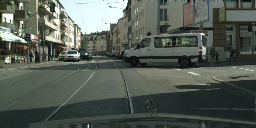

In [55]:
keras.utils.array_to_img(x[0])

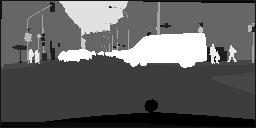

In [56]:
keras.utils.array_to_img(y[0])

In [57]:
import numpy as np

In [42]:
def get_prediction(x,model):
    pred = model.predict(x)
    prediction = np.argmax(pred,axis=3,keepdims=True)
    return prediction
    

In [43]:
prediction = get_prediction(x,benchmark_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [44]:
def show_results(x,y,prediction,count = 32):
    fig,ax = plt.subplots(
        nrows = count,
        ncols = 3,
        figsize = (10,60)
    )
    ax = ax.reshape(count,3)
    print(ax.shape)
    for a,inp_img,mask_img,pred_img in zip(ax,x[:count],y[:count],prediction[:count]):
        a[0].imshow(inp_img)
        a[0].axis('off')
        a[1].imshow(mask_img)
        a[1].axis('off')
        a[2].imshow(pred_img * 6)
        a[2].axis('off')

    plt.show()

(32, 3)


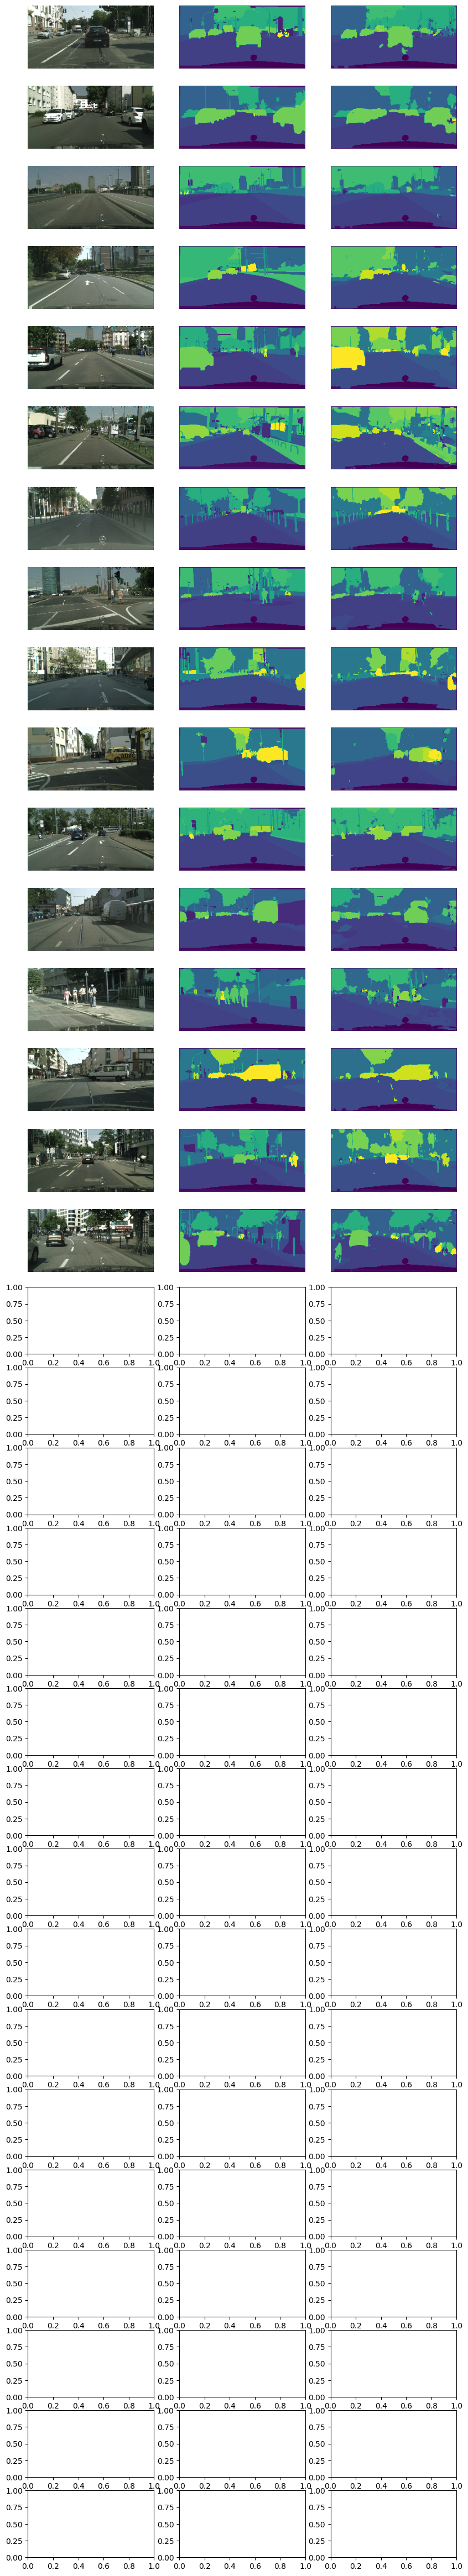

In [46]:
show_results(x,y,prediction,32)

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

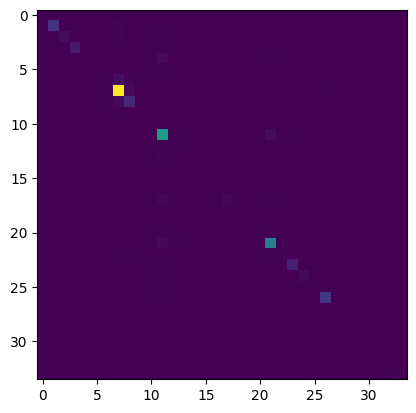

In [48]:
def get_conf_matrix(model,dataset_val):
    y_true_all = np.array([])
    y_pred_all = np.array([])
    for x, y_true in dataset_val:
        y_pred = model.predict(x,verbose = 0)
        y_pred = np.argmax(y_pred, axis=-1)  # Convert one-hot predictions to labels
        y_true_all = np.concatenate((y_true_all,y_true.numpy().flatten()))
        y_pred_all = np.concatenate((y_pred_all,y_pred.flatten()))

    conf_matrix = confusion_matrix(y_true_all, y_pred_all,labels = np.arange(34))
    plt.imshow(conf_matrix)
    return conf_matrix
conf_matrix = get_conf_matrix(benchmark_model,dataset_val)

In [ ]:
plt.imshow(conf_matrix)

In [66]:
normalized_confusion_matrix = conf_matrix.astype(np.float64) / conf_matrix.sum(axis=1)[:, np.newaxis]

/tmp/ipykernel_34/163854393.py:1: RuntimeWarning: invalid value encountered in divide
  normalized_confusion_matrix = conf_matrix.astype(np.float64) / conf_matrix.sum(axis=1)[:, np.newaxis]


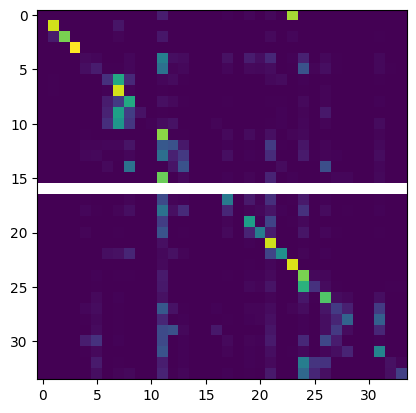

In [67]:
plt.imshow(normalized_confusion_matrix)

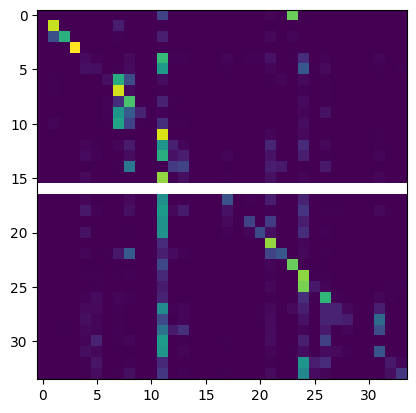

In [95]:
plt.imshow(normalized_confusion_matrix)

In [92]:
conf_matrix[:,24]

array([    30,    686,     19,      0,  30689,  19167,   7604,  59297,
        21356,    956,    317,  75030,  12556,   9167,      2,     68,
            0,  19879,    186,   2299,  12104,  37419,   2462,    181,
       153959,  24429, 123448,   3541,   2668,     12,    264,    541,
         5954,  47421])

In [82]:
most_confused_classes = np.argmax(normalized_confusion_matrix, axis=1)

In [83]:
most_confused_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

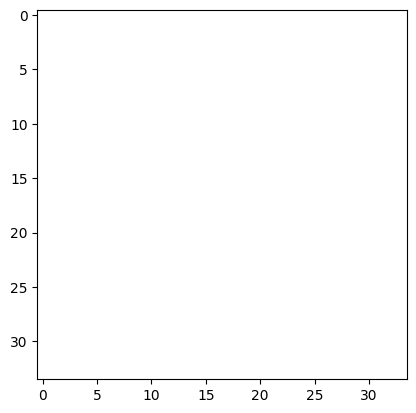

In [81]:
plt.imshow(normalized_confusion_matrix)

In [ ]:
accuracy_metric.update_state(xy)

In [32]:
benchmark_model = tf.keras.models.load_model('/kaggle/input/v1/keras/v1.001/5/Nineth_model.keras',compile = False)

In [ ]:
benchmark_model.compile(
    optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = [accuracy_metric,mean_iou]
)

In [50]:
results = benchmark_model.evaluate(dataset_val,verbose = 2,return_dict = True)

32/32 - 81s - 3s/step - loss: 0.6116 - mean_iou: 0.1841 - sparse_categorical_accuracy: 0.8314


In [ ]:
result